Imports

In [1]:
import numpy as np
import h5py
from scipy import signal
import matplotlib.pyplot as plt

Cargamos las señales

In [2]:
H1 = h5py.File('../data/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5',  'r')
L1 = h5py.File('../data/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5',  'r')

In [3]:
print(list(H1.keys()))
print(list(L1.keys()))

['meta', 'quality', 'strain']
['meta', 'quality', 'strain']


In [4]:
for element in H1['meta']:
  print(element)
for element in H1['quality']:
  print(element)
for element in H1['strain']:
  print(element)

Description
DescriptionURL
Detector
Duration
GPSstart
Observatory
Type
UTCstart
detail
injections
simple
Strain


In [5]:
metaH1 = H1[u'meta']
qualityH1 = H1[u'quality']
strainH1 = H1[u'strain']
metaL1 = L1[u'meta']
qualityL1 = L1[u'quality']
strainL1 = L1[u'strain']

In [6]:
dataH1 = np.array(strainH1['Strain'])
dataL1 = np.array(strainL1['Strain'])

In [7]:
print('strain_H1: len, min, mean, max = ', len(dataH1), dataH1.min(),dataH1.mean(),dataH1.max())
print('strain_L1: len, min, mean, max = ', len(dataL1), dataL1.min(),dataL1.mean(),dataL1.max())

strain_H1: len, min, mean, max =  131072 -7.04466594316914e-19 -3.7594485871462737e-23 7.706262192395323e-19
strain_L1: len, min, mean, max =  131072 -1.8697138664246853e-18 -1.0522364772927026e-18 -4.600351113064713e-20


In [8]:
print(dataH1)
print(dataL1)

[9.06730891e-21 2.01178871e-20 3.71290472e-20 ... 5.32101440e-20
 4.74831535e-20 7.76456828e-20]
[-1.00432555e-18 -9.58114996e-19 -9.03059379e-19 ... -1.10862808e-18
 -1.13349772e-18 -1.12487097e-18]


Ploteamos las señales

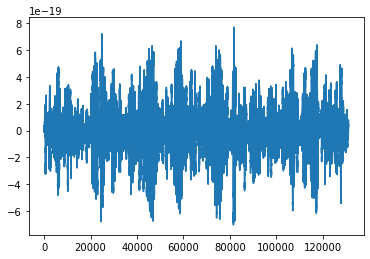

In [9]:
plt.plot(dataH1)
plt.show()

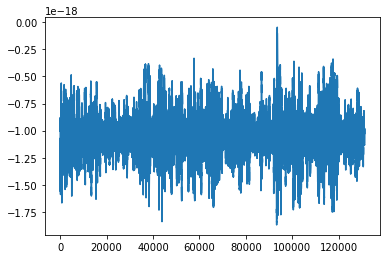

In [10]:
plt.plot(dataL1)
plt.show()

## Estimacion del espectro de potencia del ruido de H1 y L1

**Periodograma**

In [11]:
fftL1 = np.fft.fft(dataL1)
fftL1 = np.fft.fftshift(fftL1)
fftH1 = np.fft.fft(dataH1)
fftH1 = np.fft.fftshift(fftH1)

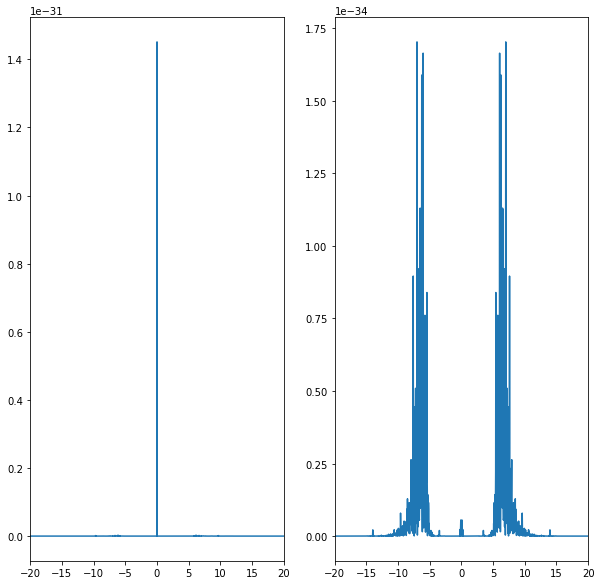

In [12]:
freqL1 = np.fft.fftfreq(len(fftL1),d=1/4096)
freqL1 = np.fft.fftshift(freqL1)
freqH1 = np.fft.fftfreq(len(fftH1),d=1/4096)
freqH1 = np.fft.fftshift(freqH1)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.plot(freqL1, abs(fftL1)**2/len(fftL1))
plt.xlim(left=-20,right=20)
plt.subplot(122)
plt.plot(freqH1, abs(fftH1)**2/len(fftH1))
plt.xlim(left=-20,right=20)
plt.show()

**Metodo Welch Bartlett**

In [13]:
def segmentation(data,D,L,K):
  return [data[x:x+L] for x in range(0,K*(L-D),L-D)]

In [14]:
def windowSegments(segments,window):
  windowed = list()
  window = np.array(window)
  segments = np.array(segments)
  for segment in segments:
    # Apply Window to segment
    windowed.append(segment*window)
  return windowed

In [15]:
def dftSegments(segments):
  dfts = list()
  for segment in segments:
    dft = np.fft.fft(segment)
    dfts.append(dft)
  return dfts

In [16]:
def spectrumSegments(dfts):
  spectrums = list()
  for segment in dfts:
    auxSpec = abs(segment)**2
    spectrums.append(auxSpec[:int(len(segment)/2)+1])
  return spectrums

In [17]:
def cumSumSpectrums(spectrums,L,fs):
  spectrum = np.zeros(len(spectrums[0]))
  norm = 2/(len(spectrums)*L*fs)
  for i in range(len(spectrums[0])):
    auxValue = 0
    for segment in spectrums:
      auxValue  = auxValue + segment[i]
    spectrum[i] = norm*auxValue
  return spectrum

In [18]:
# D: Overlap
# L: Longitud de segmentos
# K: Numero de segmentos
def welchBartlett(data,fs,D,L,k,window):
  segmentsWB = segmentation(data,D,L,k)
  windowedWB = windowSegments(segmentsWB, window)
  dftsWB = dftSegments(windowedWB)
  spectrumsWB = spectrumSegments(dftsWB)
  spectrumWB = cumSumSpectrums(spectrumsWB,L,fs)
  return spectrumWB

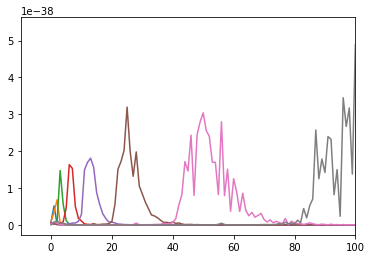

In [19]:
for i in range(8):
  nperseg = 2**(9+i)
  wbSpectrumL1 =  welchBartlett(dataL1, fs=4096, D=0, L=nperseg, k=int(len(dataL1)/nperseg), window = signal.get_window('boxcar', nperseg))
  wbSpectrumH1 =  welchBartlett(dataH1, fs=4096, D=0, L=nperseg, k=int(len(dataH1)/nperseg), window = signal.get_window('boxcar', nperseg))
  plt.plot(wbSpectrumH1)
plt.xlim(left=-10,right=100)
plt.show()

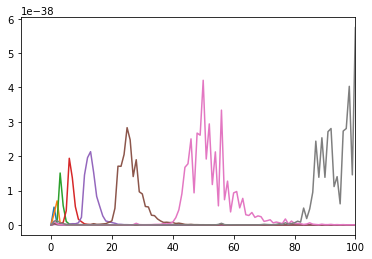

In [20]:
for i in range(8):
  nperseg = 2**(9+i)
  f, welch = signal.welch(dataH1,fs=4096,window = 'boxcar',nperseg=nperseg)
  plt.plot(welch)
plt.xlim(left=-10,right=100)
plt.show()

[]

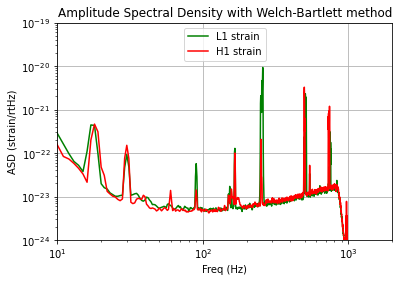

In [35]:
nperseg = 2**11
fmin = 10
fmax = 2000
Pxx_L1 =  welchBartlett(dataL1, fs=4096, D=0, L=nperseg, k=int(len(dataL1)/nperseg), window = signal.get_window('hann', nperseg))
Pxx_H1 =  welchBartlett(dataH1, fs=4096, D=0, L=nperseg, k=int(len(dataH1)/nperseg), window = signal.get_window('hann', nperseg))
plt.loglog(np.sqrt(Pxx_L1),'g',label='L1 strain')
plt.loglog(np.sqrt(Pxx_H1),'r',label='H1 strain')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Amplitude Spectral Density with Welch-Bartlett method')
plt.plot()